# Portfolio project: Biodiversity in National Parks

## Introduction

This project is focused on interpreting data from the National Parks Service about endangered species.

In particular, we are going to analyze several species of animals/plants, check their conservation status (whether they are in danger of extinction or not) and look how many weekly observations of them we have in the following US National Parks (info about their dimensions are taken [here](https://www.terragalleria.com/parks/info/national-parks-by-area.html)):

- __Yellowstone__ (2219790.71 Acres, 3,468 Sq. miles)
- __Yosemite__ (761266.19 Acres, 1,189 Sq. miles)
- __Great Smoky Mountains__ (521490.13 Acres, 815 Sq. miles)
- __Bryce__ (35835.08 Acres, 56 Sq. miles)

At the end of the analysis we can draw some conclusions about the relationship between the species mostly in danger and their habitat (i.e. the National Parks where they have been observed)

## Step one: EDA

First, we have to look at the data! There are two csv files, "species_info.csv" and "observations.csv". Let's load them and explore them with `head()`, `dtypes` and `describe()` functions:

### 1) Clean `species_info.csv`

In [456]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

species = pd.read_csv('species_info.csv')
obs = pd.read_csv('observations.csv')

species.head()

,category,scientific_name,common_names,conservation_status
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,NaN
1,Mammal,Bos bison,"American Bison, Bison",NaN
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",NaN
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",NaN
4,Mammal,Cervus elaphus,Wapiti Or Elk,NaN


In [457]:
species.dtypes

category               object
scientific_name        object
common_names           object
conservation_status    object
dtype: object

In [458]:
species.describe(include='all')

,category,scientific_name,common_names,conservation_status
count,5824,5824,5824,191
unique,7,5541,5504,4
top,Vascular Plant,Castor canadensis,Brachythecium Moss,Species of Concern
freq,4470,3,7,161


`species` DataFrame contains a list of species, described both by `scientific_names` and `common_names`, associated to their class (here described as `category`) and their `conservation_status` (i.e: whether they risk extinction or not).

Every variable here is categorical.

Looking at the `describe` output, we can see that the column `scientific_name` has some repeated value (having 5541 unique values and 5824 rows). We actually do not expect any repetitions of `scientific_name`. Nevertheless, if we check for duplicates we obtain:

In [459]:
species.duplicated().sum()

0

That's probably because the same `scientific_name` is associated to several `common_names`. Let's confirm it:

In [460]:
species[species.scientific_name == 'Castor canadensis']

,category,scientific_name,common_names,conservation_status
49,Mammal,Castor canadensis,"American Beaver, Beaver",NaN
3050,Mammal,Castor canadensis,American Beaver,NaN
4475,Mammal,Castor canadensis,Beaver,NaN


Indeed, here for the same `scientific_name` we have 3 different strings in `common_names`, even though they don't add much information. 

In order to avoid mistakes in count or sum values later on, it seems better for now to drop the `common_names` column and remove the duplicates.

In [461]:
species_no_common = species[['category','scientific_name','conservation_status']]
print(species_no_common.duplicated().sum())
species_no_common = species_no_common.drop_duplicates().reset_index(drop=True)
print(species_no_common.duplicated().sum())
species_no_common.describe()

281
0


,category,scientific_name,conservation_status
count,5543,5543,180
unique,7,5541,4
top,Vascular Plant,Oncorhynchus mykiss,Species of Concern
freq,4262,2,151


The situation has improved, but still we have some duplicates in `scientific_name`. Let's investigate why looking at *Oncorhynchus mykiss* rows:

In [462]:
species_no_common[species_no_common.scientific_name == 'Oncorhynchus mykiss']

,category,scientific_name,conservation_status
560,Fish,Oncorhynchus mykiss,NaN
3247,Fish,Oncorhynchus mykiss,Threatened


It appears that the same `scientific_name` is erroneously associated to multiple `conservation_status`. We do not actually know which one is the correct one, so we stay conservative, keeping the worse `conservation_status`. 

Let's apply that to all conflicts:

In [463]:
species_no_common.scientific_name.value_counts()

Oncorhynchus mykiss                2
Canis lupus                        2
Clethrionomys gapperi gapperi      1
Valeriana dioica var. sylvatica    1
Gaultheria humifusa                1
                                  ..
Viola pubescens                    1
Viola porterana                    1
Viola pedata                       1
Viola odorata                      1
Tribulus terrestris                1
Name: scientific_name, Length: 5541, dtype: int64

In [464]:
# We have another conflict with "Canis lupus"

species_no_common[species_no_common.scientific_name == 'Canis lupus']

,category,scientific_name,conservation_status
8,Mammal,Canis lupus,Endangered
3018,Mammal,Canis lupus,In Recovery


In [465]:
species_no_common.loc[560,'conservation_status'] = 'Threatened'
species_no_common.loc[3018,'conservation_status'] = 'Endangered'

In [466]:
print(species_no_common.duplicated().sum())
species_no_common = species_no_common.drop_duplicates().reset_index(drop=True)
print(species_no_common.duplicated().sum())
species_no_common.describe()

2
0


,category,scientific_name,conservation_status
count,5541,5541,179
unique,7,5541,4
top,Vascular Plant,Clethrionomys gapperi gapperi,Species of Concern
freq,4262,1,151


### 2) Clean `observations.csv`

In [467]:
obs.head()

,scientific_name,park_name,observations
0,Vicia benghalensis,Great Smoky Mountains National Park,68
1,Neovison vison,Great Smoky Mountains National Park,77
2,Prunus subcordata,Yosemite National Park,138
3,Abutilon theophrasti,Bryce National Park,84
4,Githopsis specularioides,Great Smoky Mountains National Park,85


In [468]:
obs.dtypes

scientific_name    object
park_name          object
observations        int64
dtype: object

In [469]:
obs.describe(include='all')

,scientific_name,park_name,observations
count,23296,23296,23296.000000
unique,5541,4,NaN
top,Myotis lucifugus,Great Smoky Mountains National Park,NaN
freq,12,5824,NaN
mean,NaN,NaN,142.287904
std,NaN,NaN,69.890532
min,NaN,NaN,9.000000
25%,NaN,NaN,86.000000
50%,NaN,NaN,124.000000
75%,NaN,NaN,195.000000


`observations` DataFrame tells us where and how many times each species considered has been observed (description on site says that observations are referred to the past 7 days). Here as well we have all descriptive and categorical data, except for "observations", which is numerical.

Looking at `dtypes` and `describe` outputs, the DataFrame seems ok:

- the number of unique `scientific_name` is the same as in `species` dataframe
- the number of unique `park_name` is 4 as expected
- the type of `observations` is int64, which means that we should not ave any NaNs.

Let's plot the histogram of `observations` in order to see if we have some outliers or some strange data shape: 

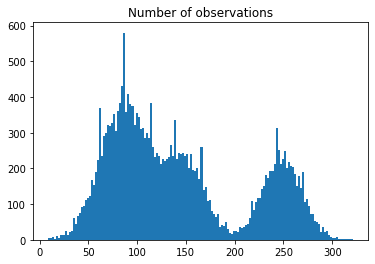

In [470]:
plt.hist(obs.observations,bins=150)
plt.title('Number of observations')
plt.show()

It looks like a bi or even tri-modal distribution. That can be due to the different species we are observing: the peak around 250 observations is probably associated to plants and flowers, while the lower peaks can be associated to animal species. Anyway, the important thing is that there's no outlier.

Now let's check if we have duplicates:

In [471]:
print(obs.duplicated().sum())
obs[obs.duplicated()]

15


,scientific_name,park_name,observations
7263,Echinochloa crus-galli,Great Smoky Mountains National Park,62
8710,Streptopelia decaocto,Yellowstone National Park,255
10038,Plantago major,Great Smoky Mountains National Park,90
10674,Arctium minus,Yosemite National Park,162
12381,Eleocharis palustris,Great Smoky Mountains National Park,62
13372,Hesperis matronalis,Bryce National Park,124
16741,Prunella vulgaris,Great Smoky Mountains National Park,75
17378,Potentilla norvegica,Yosemite National Park,148
17577,Spilogale putorius,Yellowstone National Park,256
18141,Poa compressa,Great Smoky Mountains National Park,80


We have 15 duplicates. Let's check the rows associated to *Echinochloa crus-galli*:

In [472]:
obs[obs.scientific_name == 'Echinochloa crus-galli']

,scientific_name,park_name,observations
443,Echinochloa crus-galli,Yosemite National Park,159
802,Echinochloa crus-galli,Bryce National Park,112
1454,Echinochloa crus-galli,Great Smoky Mountains National Park,62
7263,Echinochloa crus-galli,Great Smoky Mountains National Park,62
11435,Echinochloa crus-galli,Bryce National Park,116
11688,Echinochloa crus-galli,Yellowstone National Park,254
17581,Echinochloa crus-galli,Yellowstone National Park,235
17639,Echinochloa crus-galli,Yosemite National Park,172


How many are the odds that there have been 62 observations of *Echinochloa crus-galli* in two real, separate and indipendent sessions at Great Smoky Mountains National Park? It seems a little bit unreal, even though we can't exclude it a priori. 

Thus, we are going to officially keep them. Nevertheless, a parallel DataFrame without duplicates will be created, and eventually the results with and without duplicates will be compared, in order to check the weight of those repeated observations on the conclusions.

In [473]:
obs_no_dupl = obs.drop_duplicates().reset_index(drop=True)
obs_no_dupl.duplicated().sum()

0

### 3) Merge all data into one handy dataframe

Having two separate dataframe could be a problem. Since dataframes have column *scientific_name* in common, we can right merge *species_info* into *observation*: 

In [474]:
df = species_no_common.merge(obs, how='right', on='scientific_name')
df_no_dupl = species_no_common.merge(obs_no_dupl, how='right', on='scientific_name')
df.describe(include = 'all')

,category,scientific_name,conservation_status,park_name,observations
count,23296,23296,768,23296,23296.000000
unique,7,5541,4,4,NaN
top,Vascular Plant,Myotis lucifugus,Species of Concern,Great Smoky Mountains National Park,NaN
freq,17880,12,644,5824,NaN
mean,NaN,NaN,NaN,NaN,142.287904
std,NaN,NaN,NaN,NaN,69.890532
min,NaN,NaN,NaN,NaN,9.000000
25%,NaN,NaN,NaN,NaN,86.000000
50%,NaN,NaN,NaN,NaN,124.000000
75%,NaN,NaN,NaN,NaN,195.000000


### 4) dealing with NaNs

Checking the output of `describe()` function, we can understand that the only column with (a lot of) NaNs in column __conservation_status__. Let's confirm that:

In [475]:
print(df.isna().sum())

category                   0
scientific_name            0
conservation_status    22528
park_name                  0
observations               0
dtype: int64


We have 23296 rows and 22528 NaNs, almost 97% of the total. Is _conservation_status_ column a candidate for removal?

Since the objective of this research is to evaluate the status of endangered species in different parks, removing the column *conservation_status* seems a little bit reckless. Is there a reason behind those NaNs? Let's replace NaNs with string "NaN" and count the number of `observations` for each `conservation_status`:

In [476]:
df.fillna('NaN',inplace=True)
print(df[['observations','conservation_status']].groupby('conservation_status').sum().reset_index())

  conservation_status  observations
0          Endangered          2798
1         In Recovery          1392
2                 NaN       3224631
3  Species of Concern         82579
4          Threatened          3339


The number of observations for NaN cases is very much higher than any other conservation status case. In order of number of observations, we have:

- NaN
- Species of Concern
- Threatened
- Endangered
- In recovery

(Check [here](https://en.wikipedia.org/wiki/Endangered_Species_Act_of_1973) and [here](https://wildlife.ca.gov/Conservation/SSC) for further information about *Threatened*, *Endangered* and *Species of Concern* definitions)

Let's check if this unbalance exists for every `category` considered:

In [477]:
df_NaN_eval = df.groupby(['category','conservation_status']).sum().reset_index()
df_NaN_eval.pivot(index='conservation_status',columns='category',values='observations').fillna(0)

category,Amphibian,Bird,Fish,Mammal,Nonvascular Plant,Reptile,Vascular Plant
conservation_status,,,,,,,
Endangered,144.0,574.0,455.0,1463.0,0.0,0.0,162.0
In Recovery,0.0,1392.0,0.0,0.0,0.0,0.0,0.0
NaN,41219.0,254225.0,66609.0,100247.0,187948.0,42142.0,2532241.0
Species of Concern,2044.0,36642.0,2109.0,14408.0,2705.0,2536.0,22135.0
Threatened,564.0,0.0,1645.0,578.0,0.0,0.0,552.0


Looking at the table, we have the confirm that NaN is by far the most observed for each `category` considered, always followed by *Species of Concern*. We can deduce then that __NaN means "Safe species"__. We can thus substitute "NaN". with "Safe"

In [478]:
df['conservation_status'].replace(to_replace='NaN',value='Safe',inplace=True)
df_no_dupl.fillna('Safe',inplace=True) #We update also df_no_dupl dataframe, so we can make the same evaluations later on
print(df.conservation_status.unique())

['Safe' 'Species of Concern' 'Threatened' 'Endangered' 'In Recovery']


## Step Two: Data analysis

It's now time to analyze out data. Here are the questions we are going to address:

1) Which `category` has the lowest observations? Which one the highest?

2) Which `category` has the higher number of *Endangered* and *Threatened* species? How many observations of them we have?

3) Which kind of animals or plants are mostly in danger?

4) Are some categories more at risk than others (from a statistical point of view)?

5) Which park has the highest number of observations of *Endangered* and *Threatened* species? Which one has the lowest?

### Question 1: Which `category` has the lowest observations? Which one the highest?

The table and the graph below show that:

- __Amphibians and Reptiles are the ones with the lowest number of observations__ (curiously, Reptiles have a little bit more observations then Amphibian, even though being a little bit less in terms of number of species observed)
- Fishes observed just a little bit more.
- __Plants (especially Vascular Plants) are the ones most seen__.

**********************************************
TOTAL NUMBER OF OBSERVATIONS FOR EACH CATEGORY
**********************************************
                   observations
category                       
Vascular Plant          2555090
Bird                     292833
Nonvascular Plant        190653
Mammal                   116696
Fish                      70818
Reptile                   44678
Amphibian                 43971


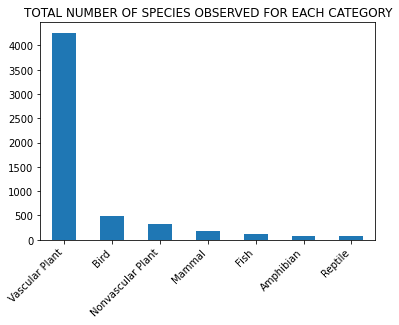

In [479]:
df_categories = df[['category','conservation_status','observations']]
quest_1 = df_categories.groupby('category').sum().sort_values(by='observations',ascending=False)
print('**********************************************')
print('TOTAL NUMBER OF OBSERVATIONS FOR EACH CATEGORY')
print('**********************************************')
print(quest_1)
species_no_common.category.value_counts(sort=True).plot(kind='bar')
plt.title('TOTAL NUMBER OF SPECIES OBSERVED FOR EACH CATEGORY')
plt.xticks(rotation=45,horizontalalignment='right')
plt.show()

### Question 2: Which `category` has the higher number of *Endangered* and *Threatened* species? How many observation of them we have?

In [487]:
quest_2_values = species_no_common[(species_no_common.conservation_status == 'Threatened')|(species_no_common.conservation_status =='Endangered')].category.value_counts()
print('***********************************************************************')
print('# OF THREATENED OR ENDANGERED SPECIES FOR EACH CATEGORY')
print('***********************************************************************')
print(quest_2_values)
quest_2 = df_categories[(df_categories.conservation_status == 'Threatened')|(df_categories.conservation_status =='Endangered')].groupby('category').sum().reset_index().sort_values(by='observations',ascending=False)
print('***********************************************************************')
print('# OF OBSERVATIONS OF THREATENED OR ENDANGERED SPECIES FOR EACH CATEGORY')
print('***********************************************************************')
print(quest_2)
#print(pd.crosstab(df_temp.category,df_temp.conservation_status,normalize='index'))
Xtab = pd.crosstab(index=df_categories.category,columns=df_categories.conservation_status,values=df_categories.observations,aggfunc=sum,normalize='index')
Xtab['Extinction'] = Xtab.Endangered + Xtab.Threatened
Xtab = Xtab.sort_values(by='Extinction',ascending=False)
print('***********************************************************************')
print('% OF OBSERVATIONS OF THREATENED OR ENDANGERED SPECIES FOR EACH CATEGORY')
print('***********************************************************************')
print(np.round((Xtab.Extinction)*100,2))

***********************************************************************
# OF THREATENED OR ENDANGERED SPECIES FOR EACH CATEGORY
***********************************************************************
Mammal            8
Fish              7
Bird              4
Vascular Plant    3
Amphibian         3
Name: category, dtype: int64
***********************************************************************
# OF OBSERVATIONS OF THREATENED OR ENDANGERED SPECIES FOR EACH CATEGORY
***********************************************************************
         category  observations
2            Fish          2100
3          Mammal          2041
4  Vascular Plant           714
0       Amphibian           708
1            Bird           574
***********************************************************************
% OF OBSERVATIONS OF THREATENED OR ENDANGERED SPECIES FOR EACH CATEGORY
***********************************************************************
category
Fish                 2.97
Mammal      

Looking at the results, we can see that:
- __Mammal__ is the category with the highest number of species in danger.
- __Fish__ is the category with both the highest number and the highest percentage of observations of threatened and endangered species.
- __Amphibians__ have a low number of observations, but the percentage of species in danger observed is just behind Fishes and Mammals.
- In contrast, *Vascular Plants* and *Birds*, despite being the categories with the highest number of observation, have a low percentage of observations of species in danger.
- Luckily, none of Nonvascular Plant and Reptile species observed is Threatened or Endangered!

In order to check possible risks in the future, let's take a look at the numbers and at the percenage of *Species of Concern* observed:

In [486]:
quest_2_bis = species_no_common[(species_no_common.conservation_status == 'Species of Concern')].category.value_counts()
print('***********************************************************************')
print('# OF SPECIES OF CONCERN FOR EACH CATEGORY')
print('***********************************************************************')
print(quest_2_bis)
print('*********************************************************')
print('% OF OBSERVATIONS OF SPECIES OF CONCERN FOR EACH CATEGORY')
print('*********************************************************')
print(np.round(Xtab['Species of Concern'].sort_values(ascending=False)*100,2))

***********************************************************************
# OF SPECIES OF CONCERN FOR EACH CATEGORY
***********************************************************************
Bird                 68
Vascular Plant       43
Mammal               22
Reptile               5
Nonvascular Plant     5
Amphibian             4
Fish                  4
Name: category, dtype: int64
*********************************************************
% OF OBSERVATIONS OF SPECIES OF CONCERN FOR EACH CATEGORY
*********************************************************
category
Bird                 12.51
Mammal               12.35
Reptile               5.68
Amphibian             4.65
Fish                  2.98
Nonvascular Plant     1.42
Vascular Plant        0.87
Name: Species of Concern, dtype: float64


We can see here that:

- __Mammals__ are still among the ones with highest percentage of species of concern observed. The risk of increasing the statistics of *Endangered* and *Threatened* statuses in the near future is quite high.
- __Birds__ and __Reptiles__ have few to no species *Endangered* or *Threatened* observed, but the percentages of species of concern observed can be a bad signal for the future.
- *Plant* situation seems quite under control.

### Question 3: Which kind of animals or plants are mostly in danger?

Let's look at the `scientific_name`s and `common_name`s of species in danger:

In [511]:
quest_3 = species_no_common[(species_no_common.conservation_status == 'Threatened')|(species_no_common.conservation_status =='Endangered')].sort_values(by='category')
common_names=[]
for name in quest_3.scientific_name:
    
    common_names.append(species[species.scientific_name == name].common_names.to_string(index=False))
quest_3['common_names'] = common_names
quest_3

,category,scientific_name,conservation_status,common_names
4385,Amphibian,Rana draytonii,Threatened,California Red-Legged Frog
4382,Amphibian,Anaxyrus canorus,Threatened,Yosemite Toad
4386,Amphibian,Rana sierrae,Endangered,Sierra Nevada Yellow-Legged Frog
4306,Bird,Gymnogyps californianus,Endangered,California Condor
173,Bird,Grus americana,Endangered,Whooping Crane
276,Bird,Vermivora bachmanii,Endangered,"Bachman's Warbler, Bachman's Wood Warbler"
343,Bird,Picoides borealis,Endangered,Red-Cockaded Woodpecker
570,Fish,Noturus baileyi,Endangered,Smoky Madtom
3238,Fish,Chasmistes liorus,Endangered,June Sucker
571,Fish,Noturus flavipinnis,Threatened,Yellowfin Madtom


We can see from the table above the species mostly in danger are:

- __Bats__ (Mammals): 2 species *Endangered*, 1 species *Threatened*
- __Wolves__ (Mammals): 2 species *Endangered* 
- __Madtoms__ (Fishes): 1 species *Endangered*, 1 species *Threatened*
- __Frogs__ (Amphibians): 1 species *Endangered*, 1 species *Threatened*
- __Trouts__ (Fishes): 2 species *Threatened*

### Question 4: Are some categories more at risk than others (from a statistical point of view)?

To answer this question, we can check how many "safe" and "in danger" species we have for each `category`, and then run a chi2 test between each `category`.

In [574]:
from scipy.stats import chi2_contingency
quest_4 = species_no_common[['category','conservation_status']].fillna('Safe')
categories = quest_4.category.unique()
for index in range(len(categories)):
    category_1 = categories[index]
    for category_2 in categories[index+1:]:
        if category_1 != category_2:
            quest_4_temp = quest_4[(quest_4.category == category_1) | (quest_4.category == category_2)]
            total_Xtab_4 = pd.crosstab(index = quest_4_temp.category, columns = quest_4_temp.conservation_status)
            total_Xtab_4['In danger'] = total_Xtab_4.sum(1) - total_Xtab_4.Safe
            reduced_Xtab_4 = total_Xtab_4[['Safe','In danger']]
            chi2,pval,dof,exp = chi2_contingency(reduced_Xtab_4)
            if pval >= 0.05:
                print("chi2 test between " + category_1 + " and " + category_2 + ", p-value = " + str(pval) + " ==> NOT SIGNIFICANT!\n")
            else:
                print("chi2 test between " + category_1 + " and " + category_2 + ", p-value = " + str(pval) + " ==> SIGNIFICANT!\n")

chi2 test between Mammal and Bird, p-value = 0.6875948096661336 ==> NOT SIGNIFICANT!

chi2 test between Mammal and Reptile, p-value = 0.03835559022969898 ==> SIGNIFICANT!

chi2 test between Mammal and Amphibian, p-value = 0.12757669693198975 ==> NOT SIGNIFICANT!

chi2 test between Mammal and Fish, p-value = 0.059485666148107276 ==> NOT SIGNIFICANT!

chi2 test between Mammal and Vascular Plant, p-value = 1.4405067309854046e-55 ==> SIGNIFICANT!

chi2 test between Mammal and Nonvascular Plant, p-value = 1.481868915759314e-10 ==> SIGNIFICANT!

chi2 test between Bird and Reptile, p-value = 0.053135422321542065 ==> NOT SIGNIFICANT!

chi2 test between Bird and Amphibian, p-value = 0.17593613249594683 ==> NOT SIGNIFICANT!

chi2 test between Bird and Fish, p-value = 0.08142210797719057 ==> NOT SIGNIFICANT!

chi2 test between Bird and Vascular Plant, p-value = 4.612268031690143e-79 ==> SIGNIFICANT!

chi2 test between Bird and Nonvascular Plant, p-value = 1.0546306904975004e-10 ==> SIGNIFICANT!



Looking at the resulting p-values, we can state that:

- Plants have a statistically significant lower rate of extinction risk compared to animals
- Among animals, a statistically significant difference in extinction risk exists only between Mammals and Reptiles (Mammals having higher risk)

### Question 5: Which park has the highest number of observations of *Endangered* and *Threatened* species? 

To answer this question, let's first check the total number of observation in each park.
As a reminder, here are the dimensions of each park considered:

- __Yellowstone__ (2219790.71 Acres, 3,468 Sq. miles)
- __Yosemite__ (761266.19 Acres, 1,189 Sq. miles)
- __Great Smoky Mountains__ (521490.13 Acres, 815 Sq. miles)
- __Bryce__ (35835.08 Acres, 56 Sq. miles)

In [395]:
obs_in_parks = df.groupby('park_name').sum().sort_values(by='observations',ascending=False)
print(obs_in_parks)

                                     observations
park_name                                        
Yellowstone National Park                 1443562
Yosemite National Park                     863332
Bryce National Park                        576025
Great Smoky Mountains National Park        431820


Let's find the number of observations per squared mile for each park:

In [396]:
dimensions_sq_mile = {'Yellowstone National Park':3468, 'Yosemite National Park':1189, 'Great Smoky Mountains National Park': 815, 'Bryce National Park':56}
obs_per_sq_mile = obs_in_parks
for park in df.park_name.unique():
    obs_per_sq_mile[obs_per_sq_mile.index == park] = round(obs_per_sq_mile[obs_per_sq_mile.index == park]/dimensions_sq_mile[park],2)
obs_per_sq_mile.sort_values(by='observations',ascending = False)

,observations
park_name,
Bryce National Park,10286.16
Yosemite National Park,726.10
Great Smoky Mountains National Park,529.84
Yellowstone National Park,416.25


The number of observations per mile is incredibly high in Bryce National Park compared to other parks!!

Let's deepen our analysis including `category` variable:

In [441]:
Xtot = pd.crosstab(index=df['park_name'],columns=df['category'],values=df['observations'],aggfunc=sum,normalize=False)
Xtot['Total'] = Xtot.sum(1)
Xtot = Xtot.sort_values(by='Total',ascending=False).drop(['Total'],axis=1)
Xtot

category,Amphibian,Bird,Fish,Mammal,Nonvascular Plant,Reptile,Vascular Plant
park_name,,,,,,,
Yellowstone National Park,19440,127251,30574,50795,83021,19554,1112927
Yosemite National Park,11444,76207,18615,30339,49783,11483,665461
Bryce National Park,7380,51647,12423,20550,32992,7950,443083
Great Smoky Mountains National Park,5707,37728,9206,15012,24857,5691,333619


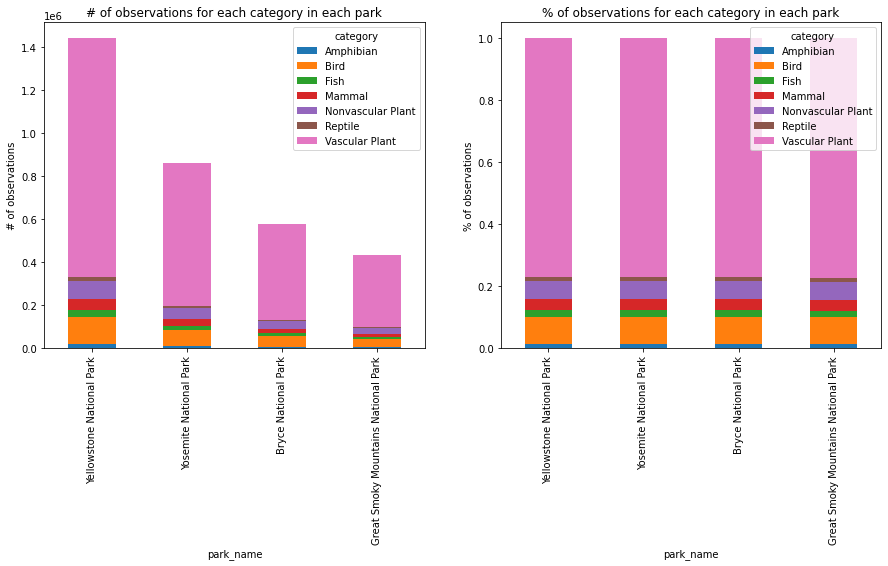

category,Amphibian,Bird,Fish,Mammal,Nonvascular Plant,Reptile,Vascular Plant
park_name,,,,,,,
Yellowstone National Park,1.35,8.82,2.12,3.52,5.75,1.35,77.10
Yosemite National Park,1.33,8.83,2.16,3.51,5.77,1.33,77.08
Bryce National Park,1.28,8.97,2.16,3.57,5.73,1.38,76.92
Great Smoky Mountains National Park,1.32,8.74,2.13,3.48,5.76,1.32,77.26


In [442]:
fig, axes = plt.subplots(nrows = 1,ncols = 2, figsize=(15,6))
Xtot.plot(kind='bar', stacked=True, ax=axes[0],title='# of observations for each category in each park',ylabel='# of observations')
Xtot = Xtot.div(Xtot.sum(axis=1), axis=0)
Xtot.plot(kind='bar', stacked=True, ax=axes[1])
plt.title('% of observations for each category in each park')
plt.ylabel('% of observations')
plt.show()
np.round(Xtot*100,2)

Looking at the graphs, we discover that the proportion of observations for each category is exactly the same in all parks.

Thus, we can state without doubts that, despite its smaller dimensions, __Bryce National Park has a very high density of living beings compared to other parks__. 

Maybe its small dimensions are the reason of such density: a smaller park is easier to examine than a bigger one. And Bryce's 56 squared miles are very much lower even than the 815 squared miles of Great Smoky Mountains. How many rangers are needed to cover all 3500 squared miles of Yellowstone park? That's huge!

Anyway, we don't know how those data have been collected from the parks, so these observations are just speculations. 
Let's move forward then and seek how many species in danger we have in each park:

In [439]:
quest_3 = df[(df.conservation_status == 'Threatened')|(df.conservation_status =='Endangered')][['category','park_name','observations']]
quest_3_ordered = pd.crosstab(index=quest_3['park_name'],columns=quest_3['category'],values=quest_3['observations'],aggfunc=sum,normalize=False)
quest_3_ordered['Total'] = quest_3_ordered.sum(1)
quest_3_ordered = quest_3_ordered.sort_values(by='Total',ascending=False)
dimensions_sq_mile_df = pd.DataFrame(dimensions_sq_mile,index=['Sq. Miles'])#'Yellowstone National Park','Yosemite National Park','Great Smoky Mountains National Park','Bryce National Park'])
dimensions_sq_mile_df = dimensions_sq_mile_df.T
quest_3_ordered['Total_norm'] = quest_3_ordered['Total'].div(dimensions_sq_mile_df['Sq. Miles'],axis=0).round(2)
quest_3_ordered

category,Amphibian,Bird,Fish,Mammal,Vascular Plant,Total,Total_norm
park_name,,,,,,,
Yellowstone National Park,315,243,920,918,291,2687,0.77
Yosemite National Park,198,172,509,526,191,1596,1.34
Bryce National Park,111,98,392,355,124,1080,19.29
Great Smoky Mountains National Park,84,61,279,242,108,774,0.95


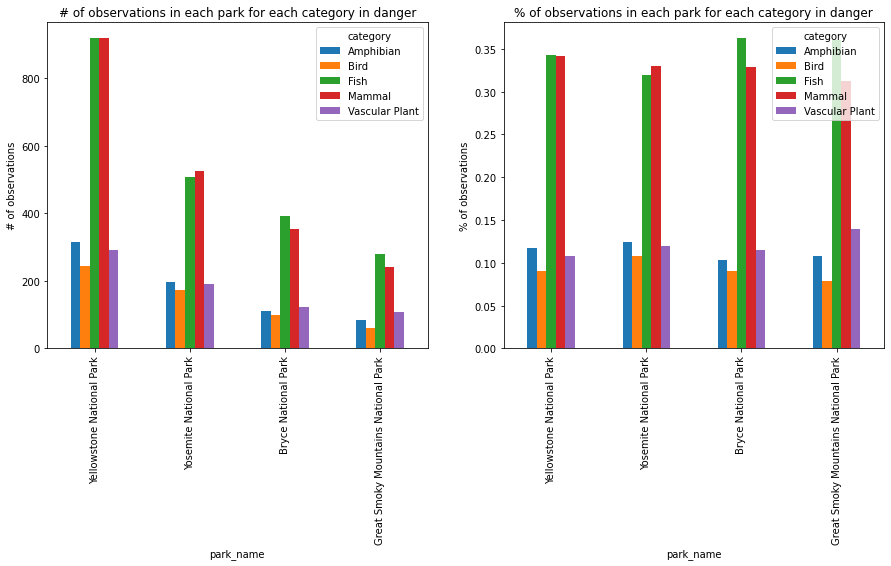

category,Amphibian,Bird,Fish,Mammal,Vascular Plant
park_name,,,,,
Yellowstone National Park,0.117231,0.090435,0.342389,0.341645,0.108299
Yosemite National Park,0.124060,0.107769,0.318922,0.329574,0.119674
Bryce National Park,0.102778,0.090741,0.362963,0.328704,0.114815
Great Smoky Mountains National Park,0.108527,0.078811,0.360465,0.312661,0.139535


In [440]:
fig, axes = plt.subplots(nrows = 1,ncols = 2, figsize=(15,6))
quest_3_ordered.drop(['Total','Total_norm'],axis=1,inplace=True)
quest_3_ordered.plot(kind='bar',ax=axes[0],title='# of observations in each park for each category in danger',ylabel='# of observations')
quest_3_ordered = quest_3_ordered.div(quest_3_ordered.sum(axis=1), axis=0)
quest_3_ordered.plot(kind='bar',ax=axes[1],title='% of observations in each park for each category in danger',ylabel='% of observations')
plt.show()
quest_3_ordered

We can see from the first table that the number of observations of species in danger (Endangered or Threatened) follows the same distribution among parks as the total number of observations, with __Bryce national park having more than 19 protected species observed per squared mile__.

Interestingly, unlike the total number of observations, the proportions of species at risk observed is slightly different between the parks:

- Fishes and Mammals are the most common in all parks. They are equally observed at Yellowstone and Yosemite parks, while at Bryce and Great Smoky Mountains parks Fishes at risk are more frequent.
- Amphibian and Vascular plants counts between 10% and 15% of observations. Amphibians are slightly more at Yellowstone and Yosemite, while Plants are more frequent at Bryce and Great Smoky Mountains.
- Birds are the least common, counting between 5% and 10% of observations, the highest amount at Yosemite, the lowest at Great Smoky Mountains.

## Step Three: Conclusions

At the end of our journey inside the nature, after analyzing data concerning several species, their conservation status and their observation in four US National Parks, we discovered a lot of things. Let's sum them up:

1) __Plants__ (in particular Vascular Plants) are the most common in all parks considered, and luckily their risk of __extinction is very low__: they have a statistically significant lower rate of risk than any other animal species considered!

2) __Mammals are the species with the highest risk of extinction__, since they are the category with the highest number of protected species. Among Mammals, __Bats are the animals more in danger__ (with 3 species *Endangered* or *Threatened*), followeb by Wolves (with 2 species *Endangered* or *Threatened*)

3) __Birds__ have a high number of observation and low number of *Endangered* or *Threatened* species. Nevertheless, they __have the highest number of *Species of concern*__, thus their situation must be monitored carefully

4) Fishes have the highest percentage of species in danger seen, despite the number of total observations not that big. __Madtoms are the fishes more in danger__, with 2 species *Engangered* or *Threatened

5) Amphibians and Reptiles have the lowest number of observations, and their conservation statuses are quite good (__Reptiles have zero *Endangered* or *Threatened* species__). Probably the low number of species influences the conservation status evaluations though.

6) __Yellowstone National Park__, being the biggest park considered (with 3468 squared miles), __is the one with the highest number of observations__, both in general and of species in danger.

7) __Bryce National Park__, despite being the smallest (with 56 squared miles), or maybe thanks to that, __is the one with the highest density of species observed__ (both in general and in danger): almost 10300 observations per squared mile, among which more than 19 are of species in danger!

## Step Four: Limitations and Future works

Even if we were able to draw some conclusions, this analysis has some limitations, such as:

 - The number of species considered is limited to the ones observed in one week. 
 
 - The observations are limited to 4 National Parks.
 
 - The analysis we have done is just a photography of the distribution of species (with their conservation status) in a specific temporal frame. We do not have any follow up (has the situation improved for Mammals? Did Birds have a worsening in their conservation status as the number of *Species of concer* was suggesting?)
 
Given these limitations, here are some possible future developments to improve the analysis:

1) Consider observation in a timespan higher than one week

2) Extend the research to more National Parks

3) Analyze several sessions of observations in multiple years, in order for instance to check whether *Species of concern* get worse or species *In recovery* get better.